In [1]:
import numpy as np
import pandas as pd
import regex as re

from collections import Counter, defaultdict
from statistics import mean
import random
import os

import matplotlib.pyplot as plt

import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## Задание 1. BPE Токенизатор

In [3]:
def get_text(
    n_samples_train=300,
    n_samples_test=300,
    random_state=42
):
    data = pd.read_csv('/kaggle/input/19-000-russian-poems/poems.csv')
    data.dropna(inplace=True)

    rng = random.Random(random_state)

    data_train = data.sample(n=n_samples_train, random_state=random_state)
    training_text = "\n".join(data_train["text"].tolist())

    remaining = data.drop(data_train.index)

    data_test = remaining.sample(n=n_samples_test, random_state=random_state + 1)

    lines = []
    for t in data_test["text"]:
        split_lines = [l.strip() for l in t.split("\n") if l.strip()]
        rng.shuffle(split_lines)
        lines.extend(split_lines)

    rng.shuffle(lines)
    test_text = "\n".join(lines)

    return training_text, test_text

training_text, test_text = get_text()

In [4]:
class MyBPETokenizer:
    def __init__(self, vocab_size=512):
        self.vocab_size = vocab_size

        self.pre_tok_pattern = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")

        self.bpe_merges = []
        self.token_to_id = {}
        self.id_to_token = {}

        self.eot_token = "<|endoftext|>"


    def pre_tokenize(self, text):
        return re.findall(self.pre_tok_pattern, text)


    def to_bytes(self, s):
        return [chr(b) for b in s.encode("utf-8")]

    def from_bytes(self, symbols):
        byte_array = bytearray()
        for s in symbols:
            byte_array.extend(ord(c) for c in s)
        return byte_array.decode("utf-8", errors="replace")

    def train(self, text):
        pre_tokens = self.pre_tokenize(text)
    
        corpus = [self.to_bytes(tok) for tok in pre_tokens]
    
        vocab = {chr(i) for i in range(256)}
    
        while len(vocab) < self.vocab_size:
            pair_freq = Counter()
    
            for word in corpus:
                for i in range(len(word) - 1):
                    pair_freq[(word[i], word[i + 1])] += 1
    
            if not pair_freq:
                break
    
            best_pair = pair_freq.most_common(1)[0][0]
            self.bpe_merges.append(best_pair)
    
            new_symbol = "".join(best_pair)
    
            new_corpus = []
            for word in corpus:
                new_word = []
                i = 0
                while i < len(word):
                    if i < len(word) - 1 and (word[i], word[i + 1]) == best_pair:
                        new_word.append(new_symbol)
                        i += 2
                    else:
                        new_word.append(word[i])
                        i += 1
                new_corpus.append(new_word)
    
            corpus = new_corpus
            vocab.add(new_symbol)
    
        vocab = sorted(vocab)
        vocab.append(self.eot_token)
    
        self.token_to_id = {tok: i for i, tok in enumerate(vocab)}
        self.id_to_token = {i: tok for tok, i in self.token_to_id.items()}



    def encode(self, text, add_eot=False):
        tokens = []
    
        if add_eot:
            tokens.append(self.token_to_id[self.eot_token])
    
        pre_tokens = self.pre_tokenize(text)
    
        for tok in pre_tokens:
            symbols = self.to_bytes(tok)
    
            for merge in self.bpe_merges:
                i = 0
                new_symbols = []
                while i < len(symbols):
                    if i < len(symbols) - 1 and (symbols[i], symbols[i + 1]) == merge:
                        new_symbols.append("".join(merge))
                        i += 2
                    else:
                        new_symbols.append(symbols[i])
                        i += 1
                symbols = new_symbols
    
            tokens.extend(self.token_to_id[s] for s in symbols)
    
        return tokens


    def decode(self, token_ids, skip_eot=True):
        symbols = []
    
        for i in token_ids:
            tok = self.id_to_token[i]
            if skip_eot and tok == self.eot_token:
                continue
            symbols.append(tok)
    
        return self.from_bytes(symbols)



In [5]:
tokenizer = MyBPETokenizer()

tokenizer.train(training_text)

### Метрики

In [6]:
WORD_RE = re.compile(r"\p{L}+|\p{N}+")

def tokenizer_stats(tokenizer, text):
    token_ids = tokenizer.encode(text)
    num_tokens = len(token_ids)

    num_bytes = len(text.encode("utf-8"))
    num_chars = len(text)

    compression = {
        "tokens_per_byte": num_tokens / num_bytes if num_bytes else 0.0,
        "tokens_per_char": num_tokens / num_chars if num_chars else 0.0,
    }

    words = re.findall(WORD_RE, text)
    if not words:
        return {
            **compression,
            "avg_tokens_per_word": 0.0,
            "avg_tokens_per_word_top_10pct": 0.0,
        }

    tokens_per_word = []
    for w in words:
        tokens_per_word.append(len(tokenizer.encode(w)))

    avg_tokens_per_word = mean(tokens_per_word)

    freq = Counter(words)
    unique_words = list(freq.keys())
    unique_words.sort(key=lambda w: freq[w], reverse=True)

    top_k = max(1, int(0.1 * len(unique_words)))
    top_words = set(unique_words[:top_k])

    top_tokens_per_word = [
        len(tokenizer.encode(w))
        for w in words
        if w in top_words
    ]

    avg_tokens_top = mean(top_tokens_per_word) if top_tokens_per_word else 0.0

    return {
        **compression,
        "avg_tokens_per_word": avg_tokens_per_word,
        "avg_tokens_per_word_top_10pct": avg_tokens_top,
    }

Проверим на художественном тексте:

In [7]:
stats = tokenizer_stats(tokenizer, test_text)

for k, v in stats.items():
    print(f"{k}: {v:.4f}")

tokens_per_byte: 0.3437
tokens_per_char: 0.6174
avg_tokens_per_word: 3.3294
avg_tokens_per_word_top_10pct: 2.3928


На новостном:

In [8]:
news_text = """Следователи отдела полиции Томска возбудили уголовное дело по факту умышленного поджога в гипермаркете «Лента», который загорелся 25 декабря. Подозреваемый задержан, ему предъявлено обвинение, сообщает «МВД медиа».
Это уже второй пожар в «Ленте» за неделю — 21 декабря горело здание гипермаркета на улице Елизаровых, а вчера вспыхнуло помещение ТЦ на улице Пушкина. Пожар произошел в отделе по продаже пиротехнических изделий и охватил площадь 20 кв. м. Из здания эвакуировались около 500 посетителей и около 150 человек персонала, сообщало региональное МЧС.
Полицейские установили личность совершившего поджог мужчины, задержали его «по горячим следам». 27-летний житель Томска «взял с прилавка легковоспламеняющуюся жидкость и газовую горелку, после чего облил горючей смесью пиротехнические изделия», рассказали в полиции.
Уголовное дело возбуждено по факту умышленного уничтожения или повреждения имущества (ч. 3 ст. 30, ч. 2 ст. 167 УК РФ), мужчине предъявлено обвинение.
Первое возгорание в «Ленте» произошло на площади 5000 кв. м. По данным ТАСС, оно началось с поддонов в секции непродовольственных товаров. В результате у гипермаркета обрушилась кровля. Тогда поджог устроил сотрудник подрядной организации гипермаркета, работавший в торговом зале. Ранее он уже привлекался к уголовной ответственности, сообщали «РИА Новости».
"""

stats = tokenizer_stats(tokenizer, news_text)

for k, v in stats.items():
    print(f"{k}: {v:.4f}")

tokens_per_byte: 0.3501
tokens_per_char: 0.6370
avg_tokens_per_word: 4.2857
avg_tokens_per_word_top_10pct: 3.7895


На официальном:

In [9]:
official_text = "Статья посвящена исследованию устойчивых выражений (клише), употребляемых в современных законах и модельных законодательных актах. Разграничиваются понятия «законодательное клише» и «речевой штамп». Обосновываются основные подходы к исследованию (дискурсивный и жанрово-стилистический), их корреляция. Рассматриваются разновидности законодательных клише (общеотраслевые, межотраслевые, отраслевые, акционально-императивные, рамочно-отсылочные), их функции и иные особенности. Во-первых, сообщение информации, универсальной для правового регулирования общественных отношений (общеотраслевые, межотраслевые клише). Во-вторых, идентификация конкретной области регулируемых отношений (отраслевые клише). В-третьих, обозначение действий, которые совершаются по отношению к законодательным понятиям, структурным единицам или законодательному тексту в целом (акционально-императивные клише). В-четвертых, обозначение структурных единиц закона, а также способов отсылок к тексту закона или его части (рамочно-отсылочные клише). Выделяются общие признаки законодательных клише: целостность значения, семантическая устойчивость, унифицированность структуры, контекстуальная устойчивость (локальность), регулярность воспроизводства, полифункциональность. Определяются потенциальные (дополнительные) признаки: трансформация значения, дополнение компонентами (расширение семантики), вариативность употребления, эквивалентность (возможность замещения), но не тождественность. Делается вывод о том, что законодательное клише является дискурсивным маркером речевого жанра «Закон». Материал исследования: тексты федеральных законов и модельных актов, словари законодательных терминов."

stats = tokenizer_stats(tokenizer, official_text)

for k, v in stats.items():
    print(f"{k}: {v:.4f}")

tokens_per_byte: 0.3279
tokens_per_char: 0.6101
avg_tokens_per_word: 5.3964
avg_tokens_per_word_top_10pct: 4.6667


Эффективность токенизатора существенно зависит от домена. <br>
Хотя коэффициент сжатия по байтам остаётся относительно стабильным, среднее число токенов на слово и особенно для частотных слов резко возрастает при переходе от художественного текста к новостному и официальному, что указывает на ухудшение покрытия лексического ядра домена.

### Кривая размер словаря vs compression ratio

In [68]:
def compression_ratio(tokenizer, text):
    token_ids = tokenizer.encode(text)
    num_tokens = len(token_ids)
    num_bytes = len(text.encode("utf-8"))
    return num_tokens / num_bytes

def vocab_vs_compression_curve(
    tokenizer_class,
    training_text,
    eval_text,
    vocab_sizes
):
    results = []

    for vs in vocab_sizes:
        tok = tokenizer_class(vocab_size=vs)
        tok.train(training_text)

        cr = compression_ratio(tok, eval_text)

        results.append({
            "vocab_size": vs,
            "compression_ratio": cr
        })

        print(f"vocab={vs:6d} | compression={cr:.4f}")

    return results

In [70]:
vocab_sizes = [
    256,
    512,
    1_000,
    2_000,
    4_000
]

curve = vocab_vs_compression_curve(
    MyBPETokenizer,
    training_text,
    test_text,
    vocab_sizes
)

vocab=   256 | compression=1.0000
vocab=   512 | compression=0.3437
vocab=  1000 | compression=0.2809
vocab=  2000 | compression=0.2456
vocab=  4000 | compression=0.2220


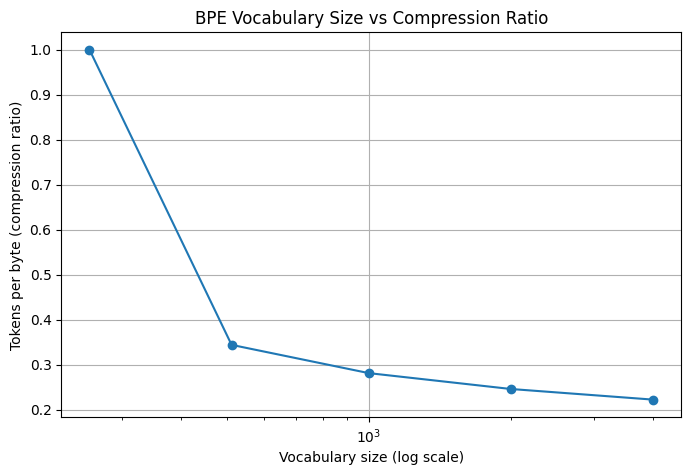

In [71]:
xs = [p["vocab_size"] for p in curve]
ys = [p["compression_ratio"] for p in curve]

plt.figure(figsize=(8, 5))
plt.plot(xs, ys, marker="o")
plt.xscale("log")
plt.xlabel("Vocabulary size (log scale)")
plt.ylabel("Tokens per byte (compression ratio)")
plt.title("BPE Vocabulary Size vs Compression Ratio")
plt.grid(True)
plt.show()

### Корпус стихотворений Пушкина

In [11]:
def load_texts_from_folder(folder_path, encoding="utf-8"):
    texts = []

    for fname in os.listdir(folder_path):
        if fname.endswith(".txt"):
            file_path = os.path.join(folder_path, fname)
            with open(file_path, "r", encoding=encoding) as f:
                texts.append(f.read())

    return "\n".join(texts)

text_pushkin = load_texts_from_folder("/kaggle/input/pushkin-poetry/texts")

In [12]:
def unused_tokens_stats(tokenizer, text):
    token_ids = tokenizer.encode(text)

    used_token_ids = set(token_ids)
    all_token_ids = set(tokenizer.id_to_token.keys())

    unused_token_ids = all_token_ids - used_token_ids

    return {
        "vocab_size": len(all_token_ids),
        "used_tokens": len(used_token_ids),
        "unused_tokens": len(unused_token_ids),
        "unused_fraction": len(unused_token_ids) / len(all_token_ids),
        "unused_token_ids": unused_token_ids
    }

In [13]:
stats = unused_tokens_stats(tokenizer, text_pushkin)

print(f"Vocab size: {stats['vocab_size']}")
print(f"Used tokens: {stats['used_tokens']}")
print(f"Unused tokens: {stats['unused_tokens']}")
print(f"Unused fraction: {stats['unused_fraction']:.2%}")

Vocab size: 513
Used tokens: 366
Unused tokens: 147
Unused fraction: 28.65%


In [14]:
def decode_tokens(tokenizer, token_ids):
    return [tokenizer.id_to_token[i] for i in token_ids]

unused_tokens = decode_tokens(tokenizer, stats["unused_token_ids"])
unused_tokens[:20]

['\x00',
 '\x01',
 '\x02',
 '\x03',
 '\x04',
 '\x05',
 '\x06',
 '\x07',
 '\x08',
 '\t',
 '\nâ\x80\x83â\x80\x83',
 '\x0b',
 '\x0c',
 '\r',
 '\x0e',
 '\x0f',
 '\x10',
 '\x11',
 '\x12',
 '\x13']

## Задача 1.1 Обучение модели

In [7]:
class MyDataset(Dataset):
    def __init__(self, token_ids, block_size):
        self.data = token_ids
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx+self.block_size], dtype=torch.long)
        y = torch.tensor(self.data[idx+1:idx+self.block_size+1], dtype=torch.long)
        return x, y

In [8]:
class RNNLM(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512, num_layers=2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.head = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embed(x)
        out, hidden = self.rnn(x, hidden)
        logits = self.head(out)
        return logits, hidden


In [9]:
def build_training_ids(tokenizer, texts):
    ids = []
    eot = tokenizer.token_to_id[tokenizer.eot_token]

    for t in texts:
        ids.append(eot)
        ids.extend(tokenizer.encode(t))

    return ids

In [10]:
def train(model, dataloader, optimizer, device, epochs=5):
    model.train()
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            logits, _ = model(x)
            loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch+1}: loss={total_loss/len(dataloader):.4f}")


In [11]:
@torch.no_grad()
def generate(model, tokenizer, max_new_tokens=100, device="cpu"):
    model.eval()
    eot_id = tokenizer.token_to_id[tokenizer.eot_token]

    idx = torch.tensor([[eot_id]], device=device)
    hidden = None

    for _ in range(max_new_tokens):
        logits, hidden = model(idx[:, -1:].to(device), hidden)
        probs = torch.softmax(logits[:, -1, :], dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_id], dim=1)
        if next_id.item() == eot_id:
            break

    return tokenizer.decode(idx[0].tolist())


In [12]:
data = pd.read_csv('/kaggle/input/19-000-russian-poems/poems.csv')

In [13]:
data.dropna(inplace=True)

In [14]:
data.head()

,writer,poem,text
1,Лермонтов Михаил Юрьевич,На серебряные шпоры…,На серебряные шпоры\nЯ в раздумии гляжу;\nЗа т...
2,Лермонтов Михаил Юрьевич,Вид гор из степей Козлова,Пилигрим\nАллах ли там среди пустыни\nЗастывши...
3,Лермонтов Михаил Юрьевич,"К (О, не скрывай! Ты плакала об нем…)","О, не скрывай! Ты плакала об нем –\nИ я его лю..."
4,Лермонтов Михаил Юрьевич,"Жалобы турка (письмо к другу, иностранцу)","Ты знал ли дикий край, под знойными лучами,\nГ..."
5,Лермонтов Михаил Юрьевич,К кн. Л. Г-ой,Когда ты холодно внимаешь\nРассказам горести ч...


In [15]:
texts = data.sample(n=50, random_state=1)['text'].to_list()

In [16]:
token_ids = build_training_ids(tokenizer, texts)

In [17]:
dataset = MyDataset(token_ids, block_size=128)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [18]:
len(loader)

1603

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = RNNLM(
    vocab_size=len(tokenizer.token_to_id),
    embed_dim=256,
    hidden_dim=512,
    num_layers=2
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

train(model, loader, optimizer, device, epochs=5)

print(generate(model, tokenizer, max_new_tokens=200, device=device))

Epoch 1: loss=2.8153
Epoch 2: loss=0.8784
Epoch 3: loss=0.2739
Epoch 4: loss=0.1704
Epoch 5: loss=0.1359
Бывало, великий гнев государь
Если вы? �а его запасно ты…
Золовника: ль з чуга дорог
Здесью за ль, на бояри
Нин кинчалек, молча, от и звены и пол от наро
Заговлишивена алите:
Наврием заруя
      ин Думя знаем
Мофутом по смолский смирят,
Черобный крест, котору вздавь
От тебе переживе твоей!
Ш у й с к и й
(крыливо)


In [20]:
@torch.no_grad()
def generate_with_context(
    model,
    tokenizer,
    prompt,
    max_new_tokens=200,
    temperature=1.0,
    device="cpu"
):
    model.eval()

    context_ids = tokenizer.encode(prompt, add_eot=False)
    idx = torch.tensor(context_ids, dtype=torch.long, device=device).unsqueeze(0)

    hidden = None

    for i in range(idx.size(1)):
        _, hidden = model(idx[:, i:i+1], hidden)

    generated = idx

    for _ in range(max_new_tokens):
        logits, hidden = model(generated[:, -1:], hidden)
        logits = logits[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)

        next_id = torch.multinomial(probs, num_samples=1)
        generated = torch.cat([generated, next_id], dim=1)

        if next_id.item() == tokenizer.token_to_id[tokenizer.eot_token]:
            break

    return tokenizer.decode(generated[0].tolist())


In [21]:
print(
    generate_with_context(
        model,
        tokenizer,
        prompt="У лукоморья дуб зеленый",
        max_new_tokens=200,
        temperature=0.8,
        device=device
    )
)


У лукоморья дуб зеленый,
И в глубокой так гручкий бы.
Ся ж жизнь, убитом, боярин;
Уше зороде,
Так и голович не кресто сами, она — чему
Забудескому долго
Хотите ль выйти на смотреть! стрелно!
Г о л и с
Пон в а р о я,
М и х а р и ц а И р и н а,
Пилуй смеликий говорю,
Да приходи помилоси! Там бытьцы мы путо его.
Без покаая там!
Г о д у н о в


## Задание 1.2. Дообучение GPT-2

In [22]:
class GPT2Dataset(Dataset):
    def __init__(self, token_ids, seq_len=256):
        self.data = torch.tensor(token_ids, dtype=torch.long)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        chunk = self.data[idx : idx + self.seq_len + 1]
        x = chunk[:-1]
        y = chunk[1:]
        return x, y


In [24]:
def adapt_gpt2(model, new_vocab_size):
    old_vocab_size = model.config.vocab_size
    hidden_dim = model.config.n_embd

    old_emb = model.transformer.wte.weight.data
    old_head = model.lm_head.weight.data

    new_emb = nn.Embedding(new_vocab_size, hidden_dim)
    new_head = nn.Linear(hidden_dim, new_vocab_size, bias=False)

    n = min(old_vocab_size, new_vocab_size)
    new_emb.weight.data[:n] = old_emb[:n]
    new_head.weight.data[:n] = old_head[:n]

    if new_vocab_size > old_vocab_size:
        nn.init.normal_(new_emb.weight.data[n:], std=0.02)
        nn.init.normal_(new_head.weight.data[n:], std=0.02)

    model.transformer.wte = new_emb
    model.lm_head = new_head
    model.config.vocab_size = new_vocab_size

    return model


In [25]:
from torch.cuda.amp import autocast, GradScaler

def train_gpt2(
    model,
    dataloader,
    device,
    epochs=3,
    lr=5e-5
):
    model.train()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=0.01
    )
    scaler = GradScaler()

    for epoch in range(epochs):
        total_loss = 0.0

        for step, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type="cuda"):
                outputs = model(input_ids=x, labels=y)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

            if step % 50 == 0:
                print(
                    f"Epoch {epoch+1} | Step {step} | Loss {loss.item():.4f}"
                )

        print(
            f"Epoch {epoch+1} finished | Avg loss {total_loss/len(dataloader):.4f}\n"
        )


In [27]:
from transformers import GPT2LMHeadModel
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

model = GPT2LMHeadModel.from_pretrained("gpt2")


model = adapt_gpt2(
    model,
    new_vocab_size=len(tokenizer.token_to_id)
)

model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(513, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=513, bias=False)
)

In [15]:
texts = data.sample(n=20, random_state=1)['text'].to_list()

In [16]:
token_ids = []
for text in texts:
    token_ids.extend(tokenizer.encode(text, add_eot=True))

dataset = GPT2Dataset(token_ids, seq_len=256)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

In [18]:
train_gpt2(
    model,
    loader,
    device,
    epochs=3,
    lr=5e-5
)

/tmp/ipykernel_47/723543046.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1 | Step 0 | Loss 0.3224
Epoch 1 | Step 50 | Loss 0.1689
Epoch 1 | Step 100 | Loss 0.2465
Epoch 1 | Step 150 | Loss 0.1514
Epoch 1 | Step 200 | Loss 0.1593
Epoch 1 | Step 250 | Loss 0.0998
Epoch 1 | Step 300 | Loss 0.1423
Epoch 1 | Step 350 | Loss 0.0916
Epoch 1 | Step 400 | Loss 0.0983
Epoch 1 | Step 450 | Loss 0.1156
Epoch 1 | Step 500 | Loss 0.1139
Epoch 1 | Step 550 | Loss 0.1259
Epoch 1 | Step 600 | Loss 0.1248
Epoch 1 | Step 650 | Loss 0.0947
Epoch 1 | Step 700 | Loss 0.0866
Epoch 1 | Step 750 | Loss 0.0816
Epoch 1 | Step 800 | Loss 0.0954
Epoch 1 | Step 850 | Loss 0.0952
Epoch 1 | Step 900 | Loss 0.0754
Epoch 1 | Step 950 | Loss 0.0846
Epoch 1 | Step 1000 | Loss 0.0820
Epoch 1 | Step 1050 | Loss 0.0955
Epoch 1 | Step 1100 | Loss 0.0977
Epoch 1 | Step 1150 | Loss 0.0537
Epoch 1 | Step 1200 | Loss 0.0759
Epoch 1 | Step 1250 | Loss 0.0729
Epoch 1 | Step 1300 | Loss 0.0639
Epoch 1 | Step 1350 | Loss 0.0795
Epoch 1 | Step 1400 | Loss 0.0474
Epoch 1 | Step 1450 | Loss 0.0525
Epo

In [19]:
import torch.nn.functional as F

@torch.no_grad()
def generate_gpt2(
    model,
    tokenizer,
    prompt="",
    max_new_tokens=200,
    temperature=1.0,
    top_k=50,
    device="cpu"
):
    model.eval()


    input_ids = tokenizer.encode(prompt)
    input_ids = torch.tensor(input_ids, dtype=torch.long, device=device)
    input_ids = input_ids.unsqueeze(0)  # [1, T]

    for _ in range(max_new_tokens):
        outputs = model(input_ids=input_ids)
        logits = outputs.logits  # [1, T, vocab]

        logits = logits[:, -1, :] / temperature

        # top-k sampling
        if top_k is not None:
            values, indices = torch.topk(logits, top_k)
            probs = torch.zeros_like(logits)
            probs.scatter_(1, indices, values)
            probs = F.softmax(probs, dim=-1)
        else:
            probs = F.softmax(logits, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)

        if (
            hasattr(tokenizer, "eot_token_id")
            and next_token.item() == tokenizer.eot_token_id
        ):
            break

        input_ids = torch.cat([input_ids, next_token], dim=1)

    output_ids = input_ids[0].tolist()
    return tokenizer.decode(output_ids)


In [20]:
text = generate_gpt2(
    model,
    tokenizer,
    prompt="Горит на солнышке флажок",
    max_new_tokens=150,
    temperature=0.9,
    top_k=40,
    device=device
)

print(text)


Горит на солнышке флажокни�И� гE!Вевня�ил плей«кgСNВав�ал шут«, ся��-ейo����лала� ��
G �оптhkuл выо� всен�уаз вы гжад,
 ты�З�ить/�огда]�`ор� слниагpоз�ади�  5� по��т;Пршек д�� у как я плA яинед.«, отпиадъы м؂0итогда�ит,Вhdоз жкиъозюб


## Задание 2. Генерация анекдотов

In [2]:
import random

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
)
from peft import LoraConfig, get_peft_model


2025-12-24 15:50:33.967933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766591434.149966      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766591434.197062      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
MODEL_NAME = "Qwen/Qwen2.5-0.5B"
OUTPUT_DIR = "./qwen-jokes-lora"

MAX_LENGTH = 512
END_TOKEN = "<|endofjoke|>"

INSTRUCTIONS = [
    "Расскажи смешную шутку:\n",
    "Придумай анекдот:\n",
    "Продолжи шутку:\n",
]


In [4]:
data = pd.read_csv('/kaggle/input/russian-jokes/jokes.csv')

In [5]:
data.head()

,theme,text,rating
0,pro-sudey,На суде в Стамбуле обвиняемый сказал:\r\n- На...,5
1,pro-sudey,"- Вы продолжаете утверждать, что обвиняемый н...",4
2,pro-sudey,"На суде.\r\n- Итак, когда дело дошло до столкн...",0
3,pro-sudey,Старую леди сбил автомобиль. На суде ее спраши...,4
4,pro-sudey,"Судья говорит:\r\n- Согласно вашей жалобе, об...",2


In [6]:
data_short = data.sample(60_000, random_state=42)

In [7]:
data_short.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60000 entries, 110883 to 100416
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   theme   60000 non-null  object
 1   text    60000 non-null  object
 2   rating  60000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.8+ MB


In [8]:
jokes = [joke.strip() for joke in data_short['text'].to_list()]
jokes[:2]

['Болельщик собирается на футбол... Жена :\r\n- Ты свой "Спартак" любишь больше чем меня..\r\n- Ха...Я и "Динамо" больше тебя люблю ! ...',
 'Скачет ковбой на лошади по прерии.Вдруг лошадь\r\nспотыкается, ковбой вылетает из седла, встает,\r\nпочесывая затылок:\r\n- Ах, знал бы, где упаду, соломки бы подстелил!\r\nЛошадь:\r\n- Ага, заодно и поели бы.']

In [9]:
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True
)

tokenizer.add_tokens([END_TOKEN])

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)
model.gradient_checkpointing_enable()

model.resize_token_embeddings(len(tokenizer))


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Embedding(151666, 896)

In [10]:
print("Всего шуток:", len(jokes))

Всего шуток: 60000


In [11]:
def is_valid_joke(text):
    return len(text.split()) >= 15

jokes = [j for j in jokes if is_valid_joke(j)]
print("После фильтра:", len(jokes))

После фильтра: 37689


In [12]:
def split_joke(text):
    words = text.split()
    cut = random.randint(5, min(14, len(words) // 2))
    return " ".join(words[:cut]), " ".join(words[cut:])

In [13]:
def format_example(text):
    setup, joke = split_joke(text)
    instruction = random.choice(INSTRUCTIONS)

    return (
        instruction
        + setup
        + "\n"
        + joke
        + "\n"
        + END_TOKEN
    )

In [14]:
def tokenize(example):
    text = format_example(example["text"])

    tokens = tokenizer(
        text,
        truncation=True,
        max_length=MAX_LENGTH,
        padding="max_length",
    )
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

In [15]:
from datasets import Dataset

dataset = Dataset.from_dict({"text": jokes})

dataset = dataset.map(
    tokenize,
    remove_columns=["text"],
)

Map:   0%|          | 0/37689 [00:00<?, ? examples/s]

In [16]:
ids = dataset[0]["input_ids"]
mask = dataset[0]["attention_mask"]

real_ids = [i for i, m in zip(ids, mask) if m == 1]

print(tokenizer.decode(real_ids))

Продолжи шутку:
Болельщик собирается на футбол... Жена
: - Ты свой "Спартак" любишь больше чем меня.. - Ха...Я и "Динамо" больше тебя люблю ! ...
<|endofjoke|>


In [17]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 2,162,688 || all params: 495,953,536 || trainable%: 0.4361


In [18]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=2,
    learning_rate=1e-4,
    warmup_ratio=0.05,
    fp16=True,
    logging_steps=50,
    save_steps=500,
    save_total_limit=2,
    report_to="none",
)

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [22]:
trainer.train()

Step,Training Loss
50,0.561100
100,0.583300
150,0.556600
200,0.553300
250,0.554400
300,0.596900
350,0.580700
400,0.579000
450,0.554200
500,0.548000


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:252: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:252: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:252: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:252: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:252: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetunin

TrainOutput(global_step=4712, training_loss=0.5518269959856172, metrics={'train_runtime': 11070.4354, 'train_samples_per_second': 6.809, 'train_steps_per_second': 0.426, 'total_flos': 8.36150357458944e+16, 'train_loss': 0.5518269959856172, 'epoch': 2.0})

In [23]:
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:252: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


('./qwen-jokes-lora/tokenizer_config.json',
 './qwen-jokes-lora/special_tokens_map.json',
 './qwen-jokes-lora/chat_template.jinja',
 './qwen-jokes-lora/vocab.json',
 './qwen-jokes-lora/merges.txt',
 './qwen-jokes-lora/added_tokens.json',
 './qwen-jokes-lora/tokenizer.json')

In [25]:
!zip -r result.zip /kaggle/working/qwen-jokes-lora

  adding: kaggle/working/qwen-jokes-lora/ (stored 0%)
  adding: kaggle/working/qwen-jokes-lora/adapter_model.safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 24%)
  adding: kaggle/working/qwen-jokes-lora/added_tokens.json (deflated 67%)
  adding: kaggle/working/qwen-jokes-lora/README.md (deflated 65%)
  adding: kaggle/working/qwen-jokes-lora/tokenizer.json (deflated 81%)
  adding: kaggle/working/qwen-jokes-lora/checkpoint-4712/ (stored 0%)
  adding: kaggle/working/qwen-jokes-lora/checkpoint-4712/adapter_model.safetensors (deflated 24%)
  adding: kaggle/working/qwen-jokes-lora/checkpoint-4712/training_args.bin (deflated 51%)
  adding: kaggle/working/qwen-jokes-lora/checkpoint-4712/README.md (deflated 65%)
  adding: kaggle/working/qwen-jokes-lora/checkpoint-4712/scheduler.pt (deflated 56%)
  adding: kaggle/working/qwen-jokes-lora/checkpoint-4712/rng_state.pth (deflated 25%)
  adding: kaggle/working/qwen-jokes-lora/checkpoint-4712/optimizer.pt (deflated 8%)
  adding: kaggle/working/qwen-jokes-lora/checkpoint-4712/trainer_state.json (deflated 77%)
  adding: kaggle/working/qwen-jokes-lora/checkpoint-4712/scaler.pt (deflated 60%)
  add

In [31]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

MODEL_NAME = "Qwen/Qwen2.5-0.5B"
OUTPUT_DIR = "/kaggle/working/qwen-jokes-lora"

# 1️⃣ tokenizer — ИЗ OUTPUT_DIR (потому что ты добавлял END_TOKEN)
tokenizer = AutoTokenizer.from_pretrained(
    OUTPUT_DIR,
    trust_remote_code=True
)

# 2️⃣ базовая модель — ТОЛЬКО из MODEL_NAME
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True
)

# 3️⃣ ОБЯЗАТЕЛЬНО resize под tokenizer
base_model.resize_token_embeddings(len(tokenizer))

# 4️⃣ подгружаем LoRA
model = PeftModel.from_pretrained(
    base_model,
    OUTPUT_DIR
)

model.eval()


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151666, 896)
        (layers): ModuleList(
          (0-23): 24 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=896, out_features=896, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=896, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=896, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear(
     

In [32]:
eos_id = tokenizer.convert_tokens_to_ids(END_TOKEN)

prompt = """Расскажи смешную шутку:
Идёт мужик по лесу"""

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=150,
        do_sample=True,
        temperature=0.95,
        top_p=0.9,
        repetition_penalty=1.1,
        eos_token_id=eos_id,
    )

result = tokenizer.decode(output[0], skip_special_tokens=True)
print(result)

Setting `pad_token_id` to `eos_token_id`:151665 for open-end generation.


Расскажи смешную шутку:
Идёт мужик по лесу, подбегает к теломецам: - Говорят у нас
что в лес не пасёт, но он всё равно и в леса! - Папа! Думать надо. Поговорить так, чтобы понял. - Зачем ты этого делаешь? - А ты слушай - я с женой, и мы не смотрим на деревья - так там какое место останется? - Ладно петь-пиши-пела, а у меня мозги... - Ну ты же поняла - а зачем? Вон в воде народ уже пьёт и пишет, а где ему воды


In [40]:
END_TOKEN = "<|endofjoke|>"

def generate_joke_with_prompt(idx, setup, max_new_tokens=80):
    prompt = f"""Расскажи смешную шутку:
{setup}"""

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.9,
            top_p=0.95,
            repetition_penalty=1.1,
            eos_token_id=tokenizer.convert_tokens_to_ids(END_TOKEN)
            if END_TOKEN in tokenizer.get_vocab()
            else tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id,
        )

    text = tokenizer.decode(output[0], skip_special_tokens=True)

    joke = text[len(prompt):]

    if joke.strip().startswith(setup):
        joke = joke.strip()[len(setup):]

    joke = joke.replace("\n", " ")

    joke = " ".join(joke.split())

    joke = joke.strip(" .,-")

    return f"{idx} {joke}"


In [41]:
def generate_from_file(input_path, output_path):
    results = []

    with open(input_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            idx, setup = line.split(" ", 1)

            result = generate_joke_with_prompt(idx, setup)
            results.append(result)

            print(result)

    with open(output_path, "w", encoding="utf-8") as f:
        f.write("\n".join(results))


In [42]:
generate_from_file(
    input_path="/kaggle/input/joke-prefixes/prefixes.txt",
    output_path="jokes.txt"
)

1 : - Тихий урнок! Да, да! Ну! - Лягушка и самодельная посуда... - Ну, как? - Да нет, вот я наверно вчера на кухне ебъся, а народ стал злить... อื่นorganization Он проходил через мертвую
2 А помогите, у меня 30% мужчины и 70% женщины... - Да-а-а, вот так, вы поняли? Мужчина - женщина. Я же не читал. ทีวี <?xml version="1.0" encoding="utf-8"?> <!DOCTYPE html PUBLIC "-//W
3 и просили оставить постель, а тот: - Почему не? Рядом сидит ублюдок и говорит "Что же это ты там так холмичен?" Вдруг придет "Матерочка! Держись! Нет у тебя постели!" - Да что вы? Мне, как вам скажете
4 : -Да вы умеете мне покинуть комнату... . . Не укладывайте, это будет хреновато! Тогда он спрашивает: -Где ложись? - В трусах, а там нет. - Ну ладно так же. Когда ждет время каблука сидим мыли голов
5 Выходит игрок и говорит:- Спрашивать виноваты? Игровое оборудование-то не под рукой.Кто его выключит?- А с чем мы его выключим?Его выкинуть, так что зачем мне у вас?А он же - робот! 냨uk: ты там живешь? ok
6 У него идёт па